# Import Libraries



In [ ]:
!pip install lazypredict
!pip install h2o
!pip install hdbscan

In [ ]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid
import h2o
from h2o.automl import H2OAutoML
import random

from imblearn.over_sampling import SMOTE

from tqdm import tqdm
import lightgbm as lgb

import time
from skimage.feature import graycomatrix, graycoprops


#####
from lazypredict.Supervised import LazyClassifier





In [ ]:
cd '/content/drive/MyDrive/ML/final_project2'

/content/drive/MyDrive/ML/final_project2


# Load and Prepare Dataset

load features , csv files , Images

**Download and unzip Dataset**

In [ ]:
!gdown 1tKCABslGetwXq9pp9pKUCHIjBYNlpeaW

Downloading...
From: https://drive.google.com/uc?id=1tKCABslGetwXq9pp9pKUCHIjBYNlpeaW
To: /content/dataset_ml.zip
100% 2.23G/2.23G [00:27<00:00, 80.7MB/s]


In [ ]:
!unzip -qq "./dataset_ml.zip"

**Read Data**

In [ ]:
#read features

# Set the random seed for reproducibility
random_seed = 123
random.seed(random_seed)

real_folder = './/real'
fake_folder = './fake'

# Read all files in the real and fake folders
real_files = [os.path.join(real_folder, file) for file in os.listdir(real_folder)]
fake_files = [os.path.join(fake_folder, file) for file in os.listdir(fake_folder)]

# Create the dataset
dataset = [(file, 'Real') for file in real_files] + [(file, 'Fake') for file in fake_files]

# Shuffle the dataset
random.shuffle(dataset)

In [ ]:
df = pd.read_csv('Features/labels.csv', header=None)
df = df.rename(columns={0: 'filename'})

# Extracting 'real/fake' information
df['real_fake'] = df['filename'].apply(lambda x: 'real' if 'real' in x else 'fake')

# Extracting 'jungle/sea/mountain' information
categories = ['jungle', 'sea', 'mountain']
df['category'] = df['filename'].apply(lambda x: next((cat for cat in categories if cat in x), None))

print(df)
df.to_csv('new_labels.csv')

                                    filename real_fake  category
0       810101213_fake_stable_mountain_2.png      fake  mountain
1        810701006_fake_stable_jungle_2.jpeg      fake    jungle
2      810199494_fake_stable_mountain_4.jpeg      fake  mountain
3          810199567_real_none_jungle_6.jpeg      real    jungle
4           810101149_real_none_jungle_1.jpg      real    jungle
...                                      ...       ...       ...
3413  810101201_fake_dallemini_jungle_5.jpeg      fake    jungle
3414    810198375_fake_stable_mountain_4.jpg      fake  mountain
3415   810199427_fake_stable_mountain_5.jpeg      fake  mountain
3416       810197636_real_none_jungle_7.jpeg      real    jungle
3417          150400011_real_none_sea_10.jpg      real       sea

[3418 rows x 3 columns]


In [ ]:
# Separate the features from the labels
features = pd.read_csv('Features/features.csv', header=None)
labels = pd.read_csv('new_labels.csv')

# Apply Min-Max scaling to the features
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(features)

# Create a new DataFrame with the normalized features and labels
normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df['Label'] = labels['real_fake']

# Split the normalized DataFrame into train, validation, and test sets
train_val_df, test_df = train_test_split(normalized_df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the "Label" column in train_df
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])

# Transform the "Label" column in val_df and test_df using the fitted encoder
val_df['Label'] = label_encoder.transform(val_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

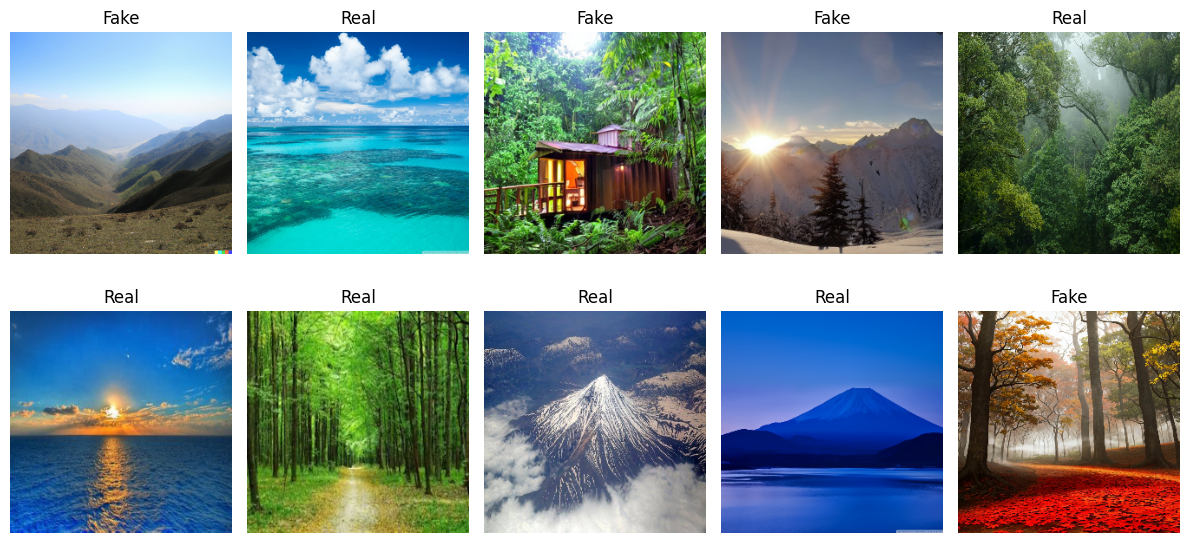

In [ ]:
# Display 10 random images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(10):
    random_index = random.randint(0, len(dataset) - 1)
    file_path, label = dataset[random_index]

    # Read the image using cv2
    image = cv2.imread(file_path)

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to a square size
    target_size = (256, 256)
    image = cv2.resize(image, target_size)

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

# Preprocess and FeatureExtracting

for preprocess we resize images
for FeatureExtracting we use : HOG , LBP , ColorHist , ..

In [ ]:
# Define Feature Extracting functions

def extract_hog_features(image):

    hog_features = feature.hog(image, orientations=9, pixels_per_cell=(8, 8),
                              cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    return hog_features


def extract_lbp_features(image):
    lbp = feature.local_binary_pattern(image, 24, 8, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)
    return lbp_hist

def extract_colorhist_features(image):
    color_hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    color_hist = cv2.normalize(color_hist, color_hist).flatten()
    return color_hist



def extract_glcm_features(image):
    # Convert the image to grayscale if necessary
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Compute the GLCM
    distances = [1]  # Distance between pixels
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Angles for co-occurrence
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Extract desired GLCM properties
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    return contrast, correlation, energy, homogeneity


def extract_gabor_features(image):
    # Convert the image to grayscale if necessary
    if len(image.shape) > 2:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Define parameters for Gabor filters
    ksize = (7, 7)  # Size of the filter kernel
    sigma = 2.0  # Standard deviation of the Gaussian envelope
    theta = np.pi / 4  # Orientation of the normal to the parallel stripes
    lambd = 10.0  # Wavelength of the sinusoidal factor
    gamma = 0.5  # Spatial aspect ratio
    psi = 0  # Phase offset

    # Create Gabor filter kernel
    gabor_kernel = cv2.getGaborKernel(ksize, sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

    # Apply Gabor filter to the image
    filtered_image = cv2.filter2D(gray_image, cv2.CV_32F, gabor_kernel)

    # Flatten the filtered image into a feature vector
    gabor_features = filtered_image.flatten()

    return gabor_features


In [ ]:
# Set the batch size
batch_size = 100

# Initialize empty lists to store features and labels
features = []
labels = []

# Process images in batches to avoid memory issues
with tqdm(total=len(dataset), desc='Extracting features') as pbar:
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        batch_features = []
        batch_labels = []

        for file_path, label in batch:
            try:
                image = cv2.imread(file_path)

                # Check if image is successfully read
                if image is None:
                    # Skip the image and its label
                    continue
                # Resize
                resized_image = cv2.resize(image, (64, 64))

                # Convert the resized image to grayscale
                gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

                # Extract features
                hog_features = extract_hog_features(gray_image)
                lbp_features = extract_lbp_features(gray_image)
                colorhist_features = extract_colorhist_features(resized_image)
                glcm_features = extract_glcm_features(resized_image)
                gabor_features = extract_gabor_features(resized_image)

                # Combine features
                combined_features = np.concatenate((hog_features, lbp_features, colorhist_features, glcm_features, gabor_features ))

                batch_features.append(combined_features)
                batch_labels.append(label)

            except Exception as e:
                print(f"Error processing image: {file_path}")
                print(f"Error message: {str(e)}")

            pbar.update(1)

        features.extend(batch_features)
        labels.extend(batch_labels)

# Convert labels to numeric format
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Create a DataFrame with features and labels
df = pd.DataFrame(features)
df['Label'] = numeric_labels

# Save the DataFrame as a CSV file
df.to_csv('image_features5_64_64.csv', index=False)

Extracting features: 100%|█████████▉| 3417/3421 [16:43<00:01,  3.41it/s]


In [ ]:
import cv2
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import re

def extract_features(feature_extractor, dataset, name):

    # Set the batch size
    batch_size = 100

    # Initialize empty lists to store features and labels
    features = []
    labels = []

    # Process images in batches to avoid memory issues
    with tqdm(total=len(dataset), desc='Extracting features') as pbar:
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i+batch_size]
            batch_features = []
            batch_labels = []

            for file_path, label in batch:
                try:
                    image = cv2.imread(file_path)

                    # Check if image is successfully read
                    if image is None:
                        # Skip the image and its label
                        continue

                    # Extract the file name from the file path
                    file_name = file_path.split('/')[-1]  # Assuming Unix-style file paths

                    # Extract the desired label from the file name
                    match = re.search(r'(jungle|sea|mountain)', file_name)
                    if match:
                        extracted_label = match.group()
                    else:
                        extracted_label = ""

                    # Resize
                    resized_image = cv2.resize(image, (64, 64))

                    # Convert the resized image to grayscale
                    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

                    # Extract features
                    if name == 'hog' or name == 'lbp':
                        extracted_features = feature_extractor(gray_image)
                    else:
                        extracted_features = feature_extractor(resized_image)

                    batch_features.append(extracted_features)
                    batch_labels.append((label, extracted_label))

                except Exception as e:
                    print(f"Error processing image: {file_path}")
                    print(f"Error message: {str(e)}")

                pbar.update(1)

            features.extend(batch_features)
            labels.extend(batch_labels)

    # Convert labels to numeric format
    label_encoder = LabelEncoder()
    numeric_labels = label_encoder.fit_transform([label for label, _ in labels])

    # Create a DataFrame with features and labels
    df = pd.DataFrame(features)
    df['Label'] = [label for label, _ in labels]
    df['Category'] = [extracted_label for _, extracted_label in labels]

    # Save the DataFrame as a CSV file
    df.to_csv(f'{name}_features_64_64.csv', index=False)


In [ ]:
extract_features(feature_extractor=extract_hog_features, dataset=dataset, name='hog')

Extracting features: 100%|█████████▉| 3417/3421 [05:52<00:00,  9.69it/s]


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/final_project2/hog_features_64_64.csv')

In [ ]:
extract_features(feature_extractor=extract_lbp_features, dataset=dataset, name='lbp')

Extracting features: 100%|█████████▉| 3417/3421 [03:48<00:00, 14.93it/s]


In [ ]:
extract_features(feature_extractor=extract_colorhist_features, dataset=dataset, name='hist')

Extracting features: 100%|█████████▉| 3417/3421 [03:26<00:00, 16.57it/s]


In [ ]:
extract_features(feature_extractor=extract_glcm_features, dataset=dataset, name='glcm')

Extracting features: 100%|█████████▉| 3417/3421 [05:29<00:00, 10.37it/s]


In [ ]:
extract_features(feature_extractor=extract_gabor_features, dataset=dataset, name='gabor')

Extracting features: 100%|█████████▉| 3417/3421 [03:27<00:00, 16.43it/s]


## Feature Selection

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming your dataframe is named 'df'
df = pd.read_csv('image_features5_64_64.csv')

# Splitting the dataframe into features (X) and target variable (y)
X = df.drop('Label', axis=1)  # Replace 'target_variable' with the name of your target column
y = df['Label']

# Splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the training set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Creating new dataframes for training, validation, and testing data
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv('image_features_train5_64_64.csv')
val_df.to_csv('image_features_val5_64_64.csv')
test_df.to_csv('image_features_test5_64_64.csv')


In [ ]:
# Remove irrelevant features and select important features
def Feature_Importance_IG(data):
    features = data.drop(['Label'],axis=1).values  # "Label" should be changed to the target class variable name if different
    labels = data['Label'].values

    # Extract feature names
    feature_names = list(data.drop(['Label'],axis=1).columns)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    model = lgb.LGBMRegressor(verbose = -1)
    model.fit(features, labels)
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})

    # Sort features according to importance
    feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index(drop = True)

    # Normalize the feature importances to add up to one
    feature_importances['normalized_importance'] = feature_importances['importance'] / feature_importances['importance'].sum()
    feature_importances['cumulative_importance'] = np.cumsum(feature_importances['normalized_importance'])

    cumulative_importance=0.90 # Only keep the important features with cumulative importance scores>=90%. It can be changed.

    # Make sure most important features are on top
    feature_importances = feature_importances.sort_values('cumulative_importance')

    # Identify the features not needed to reach the cumulative_importance
    record_low_importance = feature_importances[feature_importances['cumulative_importance'] > cumulative_importance]

    to_drop = list(record_low_importance['feature'])
#     print(feature_importances.drop(['importance'],axis=1))
    return to_drop

In [ ]:
# Remove redundant features
def Feature_Redundancy_Pearson(data):
    correlation_threshold=0.90 # Only remove features with the redundancy>90%. It can be changed
    features = data.drop(['Label'],axis=1)
    corr_matrix = features.corr()

    # Extract the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold)]

    # Dataframe to hold correlated pairs
    record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])

    # Iterate through the columns to drop
    for column in to_drop:

        # Find the correlated features
        corr_features = list(upper.index[upper[column].abs() > correlation_threshold])

        # Find the correlated values
        corr_values = list(upper[column][upper[column].abs() > correlation_threshold])
        drop_features = [column for _ in range(len(corr_features))]

        # Record the information (need a temp df for now)
        temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                         'corr_feature': corr_features,
                                         'corr_value': corr_values})
        record_collinear = record_collinear.append(temp_df, ignore_index = True)
#     print(record_collinear)
    return to_drop

In [ ]:
def Auto_Feature_Engineering_train(df):
    drop1 = Feature_Importance_IG(df)
    dfh1 = df.drop(columns = drop1)

    drop2 = Feature_Redundancy_Pearson(dfh1)
    dfh2 = dfh1.drop(columns = drop2)

    return dfh2, drop1, drop2

In [ ]:
def Auto_Feature_Engineering_val_test(df, drop1, drop2):
    dfh1 = df.drop(columns = drop1)
    dfh2 = dfh1.drop(columns = drop2)
    return dfh2

In [ ]:
df = pd.read_csv('image_features_train5_64_64.csv')
df_selected, drop1, drop2 = Auto_Feature_Engineering_train(df)
df_selected.to_csv('image_features_selected_train5_64_64.csv')

In [ ]:
df = pd.read_csv('image_features_val5_64_64.csv')
df_selected = Auto_Feature_Engineering_val_test(df, drop1, drop2)
df_selected.to_csv('image_features_selected_val5_64_64.csv')

In [ ]:
df = pd.read_csv('image_features_test5_64_64.csv')
df_selected = Auto_Feature_Engineering_val_test(df, drop1, drop2)
df_selected.to_csv('image_features_selected_test5_64_64.csv')